In [1]:
library(Seurat)
library(dplyr)
library(tidyverse)
library(Matrix)
library(CellChat)
library(patchwork)
library(stringr)
library(here)

Loading required package: SeuratObject

Loading required package: sp

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)


Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, saveRDS


Loading Seurat v5 beta version 
To maintain compatibility with previous workflows, new Seurat objects will use the previous object structure by default
To use new Seurat v5 assays: Please run: options(Seurat.object.assay.version = 'v5')


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


# Code to generate the SMC_subset Seurat object

Data from Lee _et. al._, Nature Genetics, 2020, raw scRNA-seq data accessible at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE132465.

```
require(data.table)
raw_counts <- fread(here("data", "GSE132465_GEO_processed_CRC_10X_raw_UMI_count_matrix.txt"),
    header = TRUE,
    sep = "\t",
    check.names = FALSE
) %>% as.data.frame()
rownames(raw_counts) <- raw_counts[, 1]
raw_counts <- raw_counts[, -1]

meta <- read.table(here("GSE132465_GEO_processed_CRC_10X_cell_annotation.txt"), sep = "\t", header = TRUE)
rownames(meta) <- meta[, 1]
meta <- meta[, -1]
head(meta)

SMC <- CreateSeuratObject(counts = as.sparse(raw_counts), meta.data = meta, project = "SMC")
SMC
head(SMC@meta.data)
rm(raw_counts)

unique(SMC@meta.data$Sample)
unique(SMC@meta.data$Cell_type)
unique(SMC@meta.data$Sample_type)
SMC@meta.data <- SMC@meta.data %>% separate(Sample, c("Patient", "Sample_type"), "-")

dim(SMC) # 33694 63689
SMC_subset <- subset(SMC, subset = Cell_type %in% c("Epithelial cells", "Stromal cells"))
dim(SMC_subset) # 33694  24472
rm(SMC)

SMC_subset[["percent.mt"]] <- PercentageFeatureSet(SMC_subset, pattern = "^MT-")
VlnPlot(SMC_subset, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, group.by = "Patient")
unique(SMC_subset@meta.data$Cell_subtype)

# Exploration

SMC_subset_tumour <- subset(SMC_subset, subset = Sample_type == "T")
unique(SMC_subset_tumour@meta.data$Cell_subtype)
SMC_subset_normal <- subset(SMC_subset, subset = Sample_type == "N")
unique(SMC_subset_normal@meta.data$Cell_subtype)

# ------
# ---
# Data preprocessing
# ---
# ------

# Regress to mitochondria content
sample_filt_sct <- SCTransform(SMC_subset,
    vars.to.regress = "percent.mt",
    variable.features.n = 10000
)

(cell_num_filt <- SMC_subset[["RNA"]]@data@Dim[2]) # 24472
(feature_num_filt <- SMC_subset[["RNA"]]@data@Dim[1]) # 33694

# ---
# Normalisation and data scaling
# ---

sample_filt_sct <- NormalizeData(sample_filt_sct,
    normalization.method = "LogNormalize",
    assay = "RNA"
) # normalisation
# sample_filt_sct <- ScaleData(sample_filt_sct, features = rownames(sample_filt_sct), assay = "RNA")

# ---
# Cell cycle analysis
# ---

# Curated list from Tirosh
# g2m.tirosh <- cc.genes.updated.2019$g2m.genes %>% str_to_sentence()

# CellCycle_geneSet -> collated from Tirosh and Macorsko
cc_genes <- read_tsv(here("ref", "CellCycle_geneSet.txt"))
s.features <- na.omit(cc_genes$s) %>% str_to_upper()
g2m.features <- na.omit(cc_genes$g2m) %>% str_to_upper()
g1.features <- na.omit(cc_genes$g1) %>% str_to_upper()

g1s.features <- unique(c(s.features, g1.features))
g1s.features <- setdiff(g1s.features, g2m.features) # Remove duplicates from g1s -> Check OneNote for justification

sample_filt_sct <- CellCycleScoring(sample_filt_sct,
    s.features = g1s.features,
    g2m.features = g2m.features,
    assay = "SCT",
    set.ident = TRUE
)

(g1.count <- length(WhichCells(object = sample_filt_sct, expression = Phase == "G1"))) # 4880
(g2m.count <- length(WhichCells(object = sample_filt_sct, expression = Phase == "G2M"))) # 5039
(s.count <- length(WhichCells(object = sample_filt_sct, expression = Phase == "S"))) # 14553

sample_filt_sct$CCDiff <- sample_filt_sct$S.Score - sample_filt_sct$G2M.Score # Cycling VS Quiescent

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~Normalise and regress CC~~~~~~~~~~~~~~~~~~~~~~~~~~#

sample_filt_sct <- SCTransform(sample_filt_sct,
    vars.to.regress = c("CCDiff", "percent.mt"),
    variable.features.n = 10000,
    assay = "SCT"
)

# ---
# Dimensionality Reduction
# ---

# PCA
sample_filt_sct <- RunPCA(sample_filt_sct)
VizDimLoadings(sample_filt_sct, dims = 1:4, reduction = "pca")
ElbowPlot(sample_filt_sct)
DimPlot(sample_filt_sct, reduction = "pca", group.by = "Cell_type", label = TRUE) + coord_equal()

# UMAP
sample_filt_sct <- RunUMAP(sample_filt_sct, dims = 1:48)
DimPlot(sample_filt_sct, reduction = "umap", group.by = "Cell_subtype")
DimPlot(sample_filt_sct, reduction = "umap", group.by = "old.ident")
DimPlot(sample_filt_sct, reduction = "umap", group.by = "Phase")

head(sample_filt_sct@meta.data)
unique(sample_filt_sct@meta.data$Sample_type)

p <- DimPlot(sample_filt_sct, reduction = "umap", group.by = "Sample_type") |
    DimPlot(sample_filt_sct, reduction = "umap", group.by = "Cell_subtype")
ggsave(here("output", "sample-type_cell-subtype.pdf"), width = 18, height = 5)
FeaturePlot(sample_filt_sct, features = c("EPCAM", "VIM"), reduction = "umap")
ggsave(here("output", "EPCAM-VIM.pdf"), width = 12, height = 5)

saveRDS(sample_filt_sct, here("output", "SMC_subset.rds"))

# Assign CMS subtypes

In [2]:
SMC_subset <- readRDS(here("Figure5_S5", "data", "SMC_subset.rds"))
head(SMC_subset@meta.data)


,orig.ident,Class,Patient,Sample_type,Cell_type,Cell_subtype,nCount_RNA,nFeature_RNA,percent.mt,nCount_SCT,nFeature_SCT,S.Score,G2M.Score,Phase,old.ident,CCDiff
,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<fct>,<dbl>
SMC01-T_AAACCTGCATACGCCG,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,38052,4866,12.921791,15371,3262,0.104247611,0.136362914,G2M,SMC01-T,-0.032115304
SMC01-T_AAACCTGGTCGCATAT,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,33750,5268,8.761481,15646,4365,0.083218016,-0.021782770,S,SMC01-T,0.105000786
SMC01-T_AAACCTGTCCCTTGCA,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,7356,1714,19.711800,15008,1809,0.048755347,0.005792818,S,SMC01-T,0.042962529
SMC01-T_AAACGGGAGGGAAACA,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,3752,1229,9.541578,14815,1888,0.003850734,-0.018129891,S,SMC01-T,0.021980624
SMC01-T_AAACGGGGTATAGGTA,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,23991,3914,17.314826,15495,3836,-0.019324851,-0.012019235,G1,SMC01-T,-0.007305616
SMC01-T_AAAGATGAGGCCGAAT,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,15662,3319,7.278764,15294,3309,0.151425330,0.062232901,S,SMC01-T,0.089192429


In [3]:
head(SMC_subset@meta.data)
SMC_subset_crc <- subset(SMC_subset, subset = Sample_type == "T")
SMC_subset_crc # 20205 cells

# Bulk CMS signatures
SMC_subset_crc <- AddMetaData(SMC_subset_crc,
    metadata = case_when(
        SMC_subset_crc@meta.data$Patient %in% c("SMC06", "SMC08", "SMC15", "SMC10", "SMC03") ~ "CMS1",
        SMC_subset_crc@meta.data$Patient %in%
            c("SMC22", "SMC18", "SMC21", "SMC09", "SMC23", "SMC25", "SMC11", "SMC07") ~ "CMS2",
        SMC_subset_crc@meta.data$Patient %in% c("SMC16", "SMC01", "SMC19", "SMC05") ~ "CMS3",
        SMC_subset_crc@meta.data$Patient %in% c("SMC20", "SMC14", "SMC17", "SMC04", "SMC02", "SMC24") ~ "CMS4"
    ),
    col.name = "CMS_bulk"
)
head(SMC_subset_crc@meta.data)

,orig.ident,Class,Patient,Sample_type,Cell_type,Cell_subtype,nCount_RNA,nFeature_RNA,percent.mt,nCount_SCT,nFeature_SCT,S.Score,G2M.Score,Phase,old.ident,CCDiff
,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<fct>,<dbl>
SMC01-T_AAACCTGCATACGCCG,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,38052,4866,12.921791,15371,3262,0.104247611,0.136362914,G2M,SMC01-T,-0.032115304
SMC01-T_AAACCTGGTCGCATAT,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,33750,5268,8.761481,15646,4365,0.083218016,-0.021782770,S,SMC01-T,0.105000786
SMC01-T_AAACCTGTCCCTTGCA,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,7356,1714,19.711800,15008,1809,0.048755347,0.005792818,S,SMC01-T,0.042962529
SMC01-T_AAACGGGAGGGAAACA,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,3752,1229,9.541578,14815,1888,0.003850734,-0.018129891,S,SMC01-T,0.021980624
SMC01-T_AAACGGGGTATAGGTA,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,23991,3914,17.314826,15495,3836,-0.019324851,-0.012019235,G1,SMC01-T,-0.007305616
SMC01-T_AAAGATGAGGCCGAAT,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,15662,3319,7.278764,15294,3309,0.151425330,0.062232901,S,SMC01-T,0.089192429


An object of class Seurat 
50254 features across 20205 samples within 2 assays 
Active assay: SCT (16560 features, 10000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

,orig.ident,Class,Patient,Sample_type,Cell_type,Cell_subtype,nCount_RNA,nFeature_RNA,percent.mt,nCount_SCT,nFeature_SCT,S.Score,G2M.Score,Phase,old.ident,CCDiff,CMS_bulk
,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<chr>
SMC01-T_AAACCTGCATACGCCG,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,38052,4866,12.921791,15371,3262,0.104247611,0.136362914,G2M,SMC01-T,-0.032115304,CMS3
SMC01-T_AAACCTGGTCGCATAT,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,33750,5268,8.761481,15646,4365,0.083218016,-0.021782770,S,SMC01-T,0.105000786,CMS3
SMC01-T_AAACCTGTCCCTTGCA,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,7356,1714,19.711800,15008,1809,0.048755347,0.005792818,S,SMC01-T,0.042962529,CMS3
SMC01-T_AAACGGGAGGGAAACA,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,3752,1229,9.541578,14815,1888,0.003850734,-0.018129891,S,SMC01-T,0.021980624,CMS3
SMC01-T_AAACGGGGTATAGGTA,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,23991,3914,17.314826,15495,3836,-0.019324851,-0.012019235,G1,SMC01-T,-0.007305616,CMS3
SMC01-T_AAAGATGAGGCCGAAT,SMC01-T,Tumor,SMC01,T,Epithelial cells,CMS2,15662,3319,7.278764,15294,3309,0.151425330,0.062232901,S,SMC01-T,0.089192429,CMS3


## Assign CMS + CAF grouping

In [4]:
# Group CAFs
SMC_subset_crc <- AddMetaData(SMC_subset_crc,
    metadata = case_when(
        SMC_subset_crc@meta.data$Cell_subtype %in% c("Stromal 1", "Stromal 2", "Stromal 3") ~ "CAF",
        SMC_subset_crc@meta.data$Cell_type == "Epithelial cells" ~ NA, 
        TRUE ~ SMC_subset_crc@meta.data$Cell_subtype
    ),
    col.name = "Stromal_subtype"
)
unique(SMC_subset_crc@meta.data$Stromal_subtype)

[1] NA                    "Myofibroblasts"      "CAF"                
 [4] "Stalk-like ECs"      "Tip-like ECs"        "Lymphatic ECs"      
 [7] "Pericytes"           "Proliferative ECs"   "Smooth muscle cells"
[10] "Enteric glial cells"

In [5]:
SMC_subset_crc <- AddMetaData(SMC_subset_crc,
    metadata = paste0(SMC_subset_crc@meta.data$CMS_bulk, "_", SMC_subset_crc@meta.data$Stromal_subtype),
    col.name = "CMS_Stromal_subtype"
)
unique(SMC_subset_crc@meta.data$CMS_Stromal_subtype)

[1] "CMS3_NA"                  "CMS4_NA"                 
 [3] "CMS1_NA"                  "CMS2_NA"                 
 [5] "CMS3_Myofibroblasts"      "CMS3_CAF"                
 [7] "CMS3_Stalk-like ECs"      "CMS3_Tip-like ECs"       
 [9] "CMS3_Lymphatic ECs"       "CMS3_Pericytes"          
[11] "CMS3_Proliferative ECs"   "CMS4_Myofibroblasts"     
[13] "CMS4_Tip-like ECs"        "CMS4_CAF"                
[15] "CMS4_Pericytes"           "CMS4_Proliferative ECs"  
[17] "CMS4_Stalk-like ECs"      "CMS4_Lymphatic ECs"      
[19] "CMS4_Smooth muscle cells" "CMS1_CAF"                
[21] "CMS1_Stalk-like ECs"      "CMS1_Myofibroblasts"     
[23] "CMS1_Tip-like ECs"        "CMS1_Pericytes"          
[25] "CMS1_Proliferative ECs"   "CMS4_Enteric glial cells"
[27] "CMS3_Smooth muscle cells" "CMS1_Lymphatic ECs"      
[29] "CMS1_Smooth muscle cells" "CMS2_CAF"                
[31] "CMS2_Tip-like ECs"        "CMS2_Pericytes"          
[33] "CMS2_Myofibroblasts"      "CMS2_Proliferative ECs"  
[35] "CMS2_Stalk-like ECs"      "CMS2_Lymphatic ECs"      
[37] "CMS2_Smooth muscle cells" "CMS2_Enteric glial cells"
[39] "CMS1_Enteric glial cells"

## Coalese epithelial and stromal class

In [6]:
# Set Epithelial cells to NA in the CMS_Stromal_subtype column
SMC_subset_crc@meta.data <- SMC_subset_crc@meta.data %>%
    mutate(CMS_Stromal_subtype = ifelse(Cell_type == "Epithelial cells", NA, CMS_Stromal_subtype))
unique(SMC_subset_crc@meta.data$CMS_Stromal_subtype)

# Set Stromal cells to NA in the CMS_bulk column
SMC_subset_crc@meta.data <- SMC_subset_crc@meta.data %>%
    mutate(CMS_bulk = ifelse(Cell_type == "Stromal cells", NA, CMS_bulk))
unique(SMC_subset_crc@meta.data$CMS_bulk)

SMC_subset_crc@meta.data$CMS_bulk <- coalesce(
    SMC_subset_crc@meta.data$CMS_bulk,
    SMC_subset_crc@meta.data$CMS_Stromal_subtype
)
unique(SMC_subset_crc@meta.data$CMS_bulk)

[1] NA                         "CMS3_Myofibroblasts"     
 [3] "CMS3_CAF"                 "CMS3_Stalk-like ECs"     
 [5] "CMS3_Tip-like ECs"        "CMS3_Lymphatic ECs"      
 [7] "CMS3_Pericytes"           "CMS3_Proliferative ECs"  
 [9] "CMS4_Myofibroblasts"      "CMS4_Tip-like ECs"       
[11] "CMS4_CAF"                 "CMS4_Pericytes"          
[13] "CMS4_Proliferative ECs"   "CMS4_Stalk-like ECs"     
[15] "CMS4_Lymphatic ECs"       "CMS4_Smooth muscle cells"
[17] "CMS1_CAF"                 "CMS1_Stalk-like ECs"     
[19] "CMS1_Myofibroblasts"      "CMS1_Tip-like ECs"       
[21] "CMS1_Pericytes"           "CMS1_Proliferative ECs"  
[23] "CMS4_Enteric glial cells" "CMS3_Smooth muscle cells"
[25] "CMS1_Lymphatic ECs"       "CMS1_Smooth muscle cells"
[27] "CMS2_CAF"                 "CMS2_Tip-like ECs"       
[29] "CMS2_Pericytes"           "CMS2_Myofibroblasts"     
[31] "CMS2_Proliferative ECs"   "CMS2_Stalk-like ECs"     
[33] "CMS2_Lymphatic ECs"       "CMS2_Smooth muscle cells"
[35] "CMS2_Enteric glial cells" "CMS1_Enteric glial cells"

[1] "CMS3" "CMS4" "CMS1" "CMS2" NA

[1] "CMS3"                     "CMS4"                    
 [3] "CMS1"                     "CMS2"                    
 [5] "CMS3_Myofibroblasts"      "CMS3_CAF"                
 [7] "CMS3_Stalk-like ECs"      "CMS3_Tip-like ECs"       
 [9] "CMS3_Lymphatic ECs"       "CMS3_Pericytes"          
[11] "CMS3_Proliferative ECs"   "CMS4_Myofibroblasts"     
[13] "CMS4_Tip-like ECs"        "CMS4_CAF"                
[15] "CMS4_Pericytes"           "CMS4_Proliferative ECs"  
[17] "CMS4_Stalk-like ECs"      "CMS4_Lymphatic ECs"      
[19] "CMS4_Smooth muscle cells" "CMS1_CAF"                
[21] "CMS1_Stalk-like ECs"      "CMS1_Myofibroblasts"     
[23] "CMS1_Tip-like ECs"        "CMS1_Pericytes"          
[25] "CMS1_Proliferative ECs"   "CMS4_Enteric glial cells"
[27] "CMS3_Smooth muscle cells" "CMS1_Lymphatic ECs"      
[29] "CMS1_Smooth muscle cells" "CMS2_CAF"                
[31] "CMS2_Tip-like ECs"        "CMS2_Pericytes"          
[33] "CMS2_Myofibroblasts"      "CMS2_Proliferative ECs"  
[35] "CMS2_Stalk-like ECs"      "CMS2_Lymphatic ECs"      
[37] "CMS2_Smooth muscle cells" "CMS2_Enteric glial cells"
[39] "CMS1_Enteric glial cells"

# CellChat Analysis

An object of class Seurat 
50254 features across 17824 samples within 2 assays 
Active assay: SCT (16560 features, 10000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

[1] "CMS3"     "CMS4"     "CMS1"     "CMS2"     "CMS3_CAF" "CMS4_CAF" "CMS1_CAF"
[8] "CMS2_CAF"

[1] "Create a CellChat object from a Seurat object"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  CMS1 CMS1_CAF CMS2 CMS2_CAF CMS3 CMS3_CAF CMS4 CMS4_CAF 
triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2023-07-13 17:34:52.471126]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-07-13 17:37:14.017209]"


Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways

Warning message:
"The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.
i The deprecated feature was likely used in the CellChat package.
  Please report the issue to the authors."


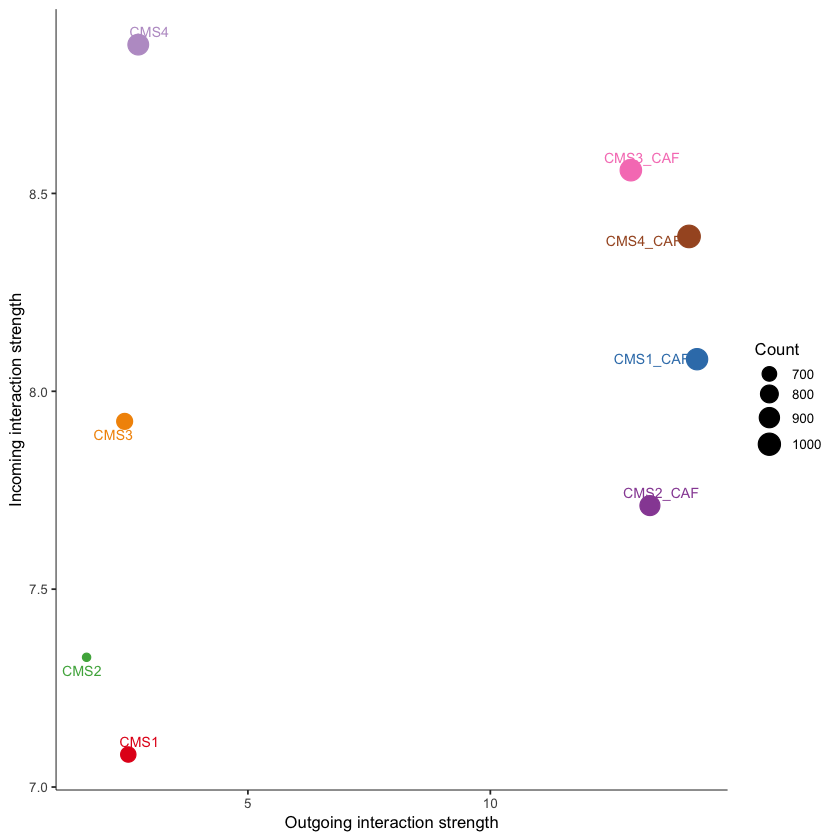

In [7]:
SMC_subset_crc_subset <- subset(
    SMC_subset_crc,
    subset = (CMS_bulk %in% c(
        # "proCSC_Q1", "proCSC_Q2", "proCSC_Q3", "proCSC_Q4",
        "CMS1", "CMS2", "CMS3", "CMS4",
        # "Mature Enterocytes type 1", "Mature Enterocytes type 2", "Stem-like/TA", "Goblet cells",
        # "Myofibroblasts",
        # "Stromal 1", "Stromal 2", "Stromal 3"
        # "CAF"
        "CMS1_CAF", "CMS2_CAF", "CMS3_CAF", "CMS4_CAF"
    ))
)
SMC_subset_crc_subset
unique(SMC_subset_crc_subset@meta.data$CMS_bulk)

cc_SMC_subset_crc_subset <- createCellChat(
    object = SMC_subset_crc_subset,
    meta = SMC_subset_crc_subset@meta.data,
    group.by = "CMS_bulk",
    assay = "RNA",
    do.sparse = TRUE
)

cc_SMC_subset_crc_subset@DB <- CellChatDB.human
cc_SMC_subset_crc_subset <- subsetData(cc_SMC_subset_crc_subset)
# future::plan("multisession", workers = 12) # do parallel
cc_SMC_subset_crc_subset <- identifyOverExpressedGenes(cc_SMC_subset_crc_subset)
cc_SMC_subset_crc_subset <- identifyOverExpressedInteractions(cc_SMC_subset_crc_subset)
cc_SMC_subset_crc_subset <- computeCommunProb(cc_SMC_subset_crc_subset)
cc_SMC_subset_crc_subset <- filterCommunication(cc_SMC_subset_crc_subset, min.cells = 12)
cc_SMC_subset_crc_subset <- computeCommunProbPathway(cc_SMC_subset_crc_subset, thresh = 0.05)
cc_SMC_subset_crc_subset <- aggregateNet(cc_SMC_subset_crc_subset)
cc_SMC_subset_crc_subset <- netAnalysis_computeCentrality(cc_SMC_subset_crc_subset, slot.name = "netP")
netAnalysis_signalingRole_scatter(cc_SMC_subset_crc_subset)

## Interaction strengths

In [9]:
bind_rows(
        subsetCommunication(cc_SMC_subset_crc_subset, sources.use = c("CMS1_CAF"), targets.use = c("CMS1")) %>% summarise(sum(prob)),
        subsetCommunication(cc_SMC_subset_crc_subset, sources.use = c("CMS2_CAF"), targets.use = c("CMS2")) %>% summarise(sum(prob)),
        subsetCommunication(cc_SMC_subset_crc_subset, sources.use = c("CMS3_CAF"), targets.use = c("CMS3")) %>% summarise(sum(prob)),
        subsetCommunication(cc_SMC_subset_crc_subset, sources.use = c("CMS4_CAF"), targets.use = c("CMS4")) %>% summarise(sum(prob)),
        .id = "CMS"
)

CMS,sum(prob)
<chr>,<dbl>
1,1.621168
2,1.572517
3,1.625700
4,2.029576
